In [18]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

In [19]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [20]:
pd.options.display.float_format = '{:,.4f}'.format

In [21]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning:

Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/



In [5]:
hours_viewed = run_query('SELECT * FROM max_dev.workspace.user_title_hours_watched_crossvalidation')

In [6]:
hours_viewed.head()

,title_name,title_id,season_number,offering_start_date,air_date,asset_run_time_hours,content_category,program_type,medal,pillar_genre,is_pay_1,is_popcorn,medal_number,age_of_content,content_cost,average_hours_viewed,log_average_hours_viewed,pred_logged,prediction,pct_error
0,It,GWt7vKAJzFri8vQEAAAKm,0,2020-10-27,2017-01-01,2.1964,movies,acquired,None,Horror,0,0,4,3.8194,9029193,0.0585,-4.0943,-4.1212,0.0575,0.0185
1,Snow White and the Huntsman,GX42eRA3gLmNViQEAAAYP,0,2020-12-01,2012-06-01,2.0739,movies,acquired,None,Action/Adventure,0,0,4,8.5012,3646400,0.0484,-4.3680,-3.5002,0.0884,0.8249
2,The Bee Gees: How Can You Mend A Broken Heart,GX5lfBgOJ7RKRwgEAAAMG,0,2020-12-13,2020-12-12,1.8503,movies,original,Silver,Documentary,0,0,2,0.0027,4500000,0.1034,-3.2737,-3.5817,0.0835,0.1922
3,Deathstroke: Knights & Dragons,GX9jvbw7CW3idqQEAAABV,0,2021-01-01,2020-08-18,1.4161,movies,acquired,None,Action/Adventure,0,0,4,0.3724,1080000,0.0330,-4.9221,-3.8342,0.0701,1.1256
4,Chernobyl,GXJvkMAU0JIG6gAEAAAIo,1,2020-05-27,2019-06-03,5.2950,series,original,None,Drama,0,0,4,0.9829,16200000,0.0394,-4.6653,-3.9352,0.0654,0.6588


In [ ]:
vote_share = run_query('''SELECT *
                    FROM MAX_PROD.WORKSPACE.DAILY_CONTENT_VALUATION_METRICS_COMBINED 
                    where  1=1
                    -- AND days_on_hbo_max = 60
                    and region = 'NORTH AMERICA'
                    and LEGACY_HBOMAX_SERIES_VIEWABLE_ID = 'GV-54_wnG7qbCwwEAAAAY'
                    and REQUEST_DATE < '2020-07-01' and REQUEST_DATE >= '2020-06-01'
                    ORDER BY days_on_hbo_max
                    ''')

In [56]:
vote_share.head()

,title_id,season_number,v_share
0,GX_Ob2gCXEKmohAEAAAAC,0.0000,0.000386498413
1,GYJLPwAnMvbSdwwEAAAD8,7.0000,0.000254930564
2,GXa5NxQH_E5GYoAEAAAAl,1.0000,0.000006679883
3,GYB3SAQKmr698pQEAAABL,1.0000,0.014606378387
4,GYGM-zQ4fFMJPwwEAAAAZ,0.0000,0.000122185640


In [36]:
hours_viewed_vs = hours_viewed.merge(vote_share, on = ['title_id', 'season_number'], how = 'left')

In [14]:
hours_viewed_vs[hours_viewed_vs['v_share'].isnull()]

,title_name,title_id,season_number,offering_start_date,air_date,asset_run_time_hours,content_category,program_type,medal,pillar_genre,is_pay_1,is_popcorn,medal_number,age_of_content,content_cost,average_hours_viewed,log_average_hours_viewed,pred_logged,prediction,pct_error,v_share
823,Sherlock Holmes: A Game Of Shadows,GXoa09ws-QrDCYwEAAAMc,0,2020-06-01,2011-12-16,2.1444,movies,acquired,None,Suspense/Thriller,0,0,4,8.4601,0,0.0325,-4.9452,-3.7901,0.0723,1.2271,NaN
844,300,GYJWdJAUshsPCwgEAAABc,0,2022-01-01,2007-01-01,1.8839,movies,acquired,None,Action/Adventure,0,0,4,15.0010,990000,0.0670,-3.8995,-3.8662,0.0686,0.0233,NaN
883,Green Lantern,GXXAljgW4WcPCwgEAAAHP,0,2020-05-27,2011-06-17,1.9156,movies,acquired,None,Action/Adventure,0,0,4,8.9447,60000,0.0314,-4.9951,-3.4407,0.0921,1.9372,NaN
884,Euphoria Special Episode Part 2: Jules,GX_4Yaww4-L6pXwEAAAAE,0,2021-01-23,2021-01-22,0.8053,special,original,Silver,Other,0,0,2,0.0027,0,0.1206,-3.0515,-2.9842,0.1264,0.0478,NaN
1107,Rampage,GX9q5dgUGL8ILwgEAAAFw,0,2021-01-01,2018-01-01,1.7383,movies,acquired,None,Action/Adventure,0,0,4,3.0007,3367607,0.2054,-2.2833,-3.5322,0.0864,0.5792,NaN
1116,Shazam!,GXXKT8Ae_jqnCVgEAAAOa,0,2020-05-27,2019-04-05,2.1944,movies,acquired,None,Action/Adventure,1,0,4,1.1444,40000,0.1036,-3.2710,-3.6815,0.0779,0.2476,NaN
1137,Dumb & Dumber,GXtlhCgtvX5uSkwEAAATC,0,2020-07-01,1994-01-01,1.7386,movies,acquired,None,Comedy,0,0,4,26.4975,3026250,0.0713,-3.8095,-4.1721,0.0555,0.2222,NaN
1154,Harry Potter: Hogwarts Tournament of Houses,GYZ9MrgqYWBq0wwEAAAAF,1,2022-01-01,2021-01-01,2.8681,series,acquired,None,Unscripted,0,0,4,0.9993,0,0.0837,-3.5782,-3.6856,0.0777,0.0717,NaN
1174,13 Going on 30,GX4iIawx27GNViQEAAAOP,0,2020-11-01,2004-01-01,1.6292,movies,acquired,None,None,0,0,4,16.8354,0,0.0341,-4.8755,-4.2064,0.0542,0.5902,NaN
1178,Ready Player One,GX9q5dgf0LMILwgEAAAF0,0,2021-01-01,2018-01-01,2.2603,movies,acquired,None,Action/Adventure,0,0,4,3.0007,4819157,0.2841,-1.8154,-3.5544,0.0851,0.7004,NaN


In [15]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [37]:
hours_viewed_vs.head()

,title_name,title_id,season_number,offering_start_date,air_date,asset_run_time_hours,content_category,program_type,medal,pillar_genre,is_pay_1,is_popcorn,medal_number,age_of_content,content_cost,average_hours_viewed,log_average_hours_viewed,pred_logged,prediction,pct_error,v_share
0,It,GWt7vKAJzFri8vQEAAAKm,0,2020-10-27,2017-01-01,2.1964,movies,acquired,None,Horror,0,0,4,3.8194,9029193,0.0585,-4.0943,-4.1212,0.0575,0.0185,0.002928350274
1,Snow White and the Huntsman,GX42eRA3gLmNViQEAAAYP,0,2020-12-01,2012-06-01,2.0739,movies,acquired,None,Action/Adventure,0,0,4,8.5012,3646400,0.0484,-4.3680,-3.5002,0.0884,0.8249,0.001298312603
2,The Bee Gees: How Can You Mend A Broken Heart,GX5lfBgOJ7RKRwgEAAAMG,0,2020-12-13,2020-12-12,1.8503,movies,original,Silver,Documentary,0,0,2,0.0027,4500000,0.1034,-3.2737,-3.5817,0.0835,0.1922,0.004515435755
3,Deathstroke: Knights & Dragons,GX9jvbw7CW3idqQEAAABV,0,2021-01-01,2020-08-18,1.4161,movies,acquired,None,Action/Adventure,0,0,4,0.3724,1080000,0.0330,-4.9221,-3.8342,0.0701,1.1256,0.000496565159
4,Chernobyl,GXJvkMAU0JIG6gAEAAAIo,1,2020-05-27,2019-06-03,5.2950,series,original,None,Drama,0,0,4,0.9829,16200000,0.0394,-4.6653,-3.9352,0.0654,0.6588,0.002757910597


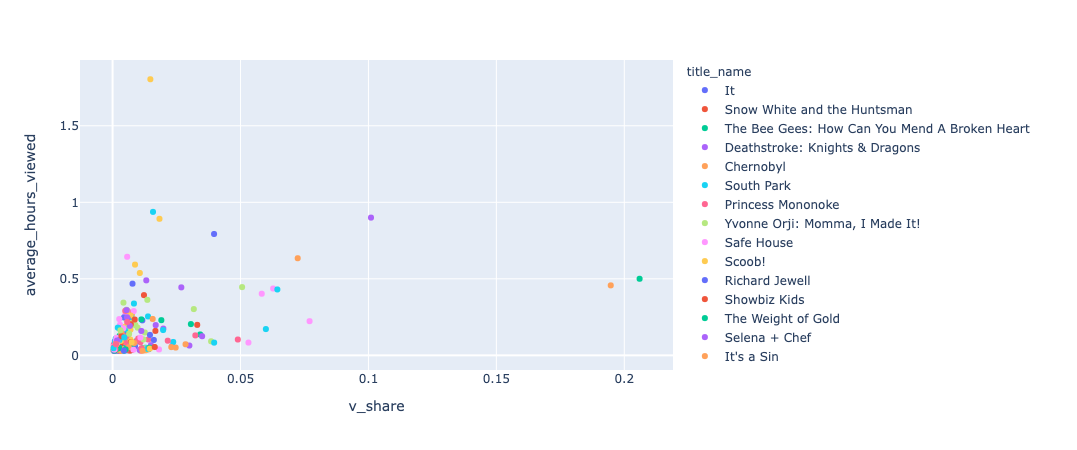

In [38]:
fig = px.scatter(hours_viewed_vs, x="v_share", y="average_hours_viewed", color='title_name')
fig.show()

In [39]:
hours_viewed_vs['tt_hours_viewed'] = hours_viewed_vs['average_hours_viewed']*hours_viewed_vs['asset_run_time_hours']

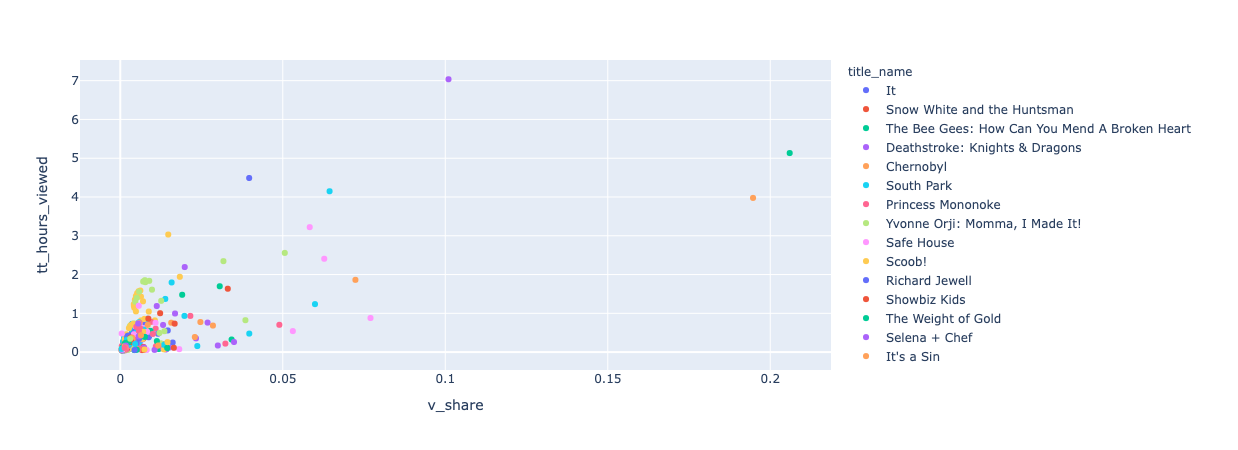

In [40]:
fig = px.scatter(hours_viewed_vs, x="v_share", y="tt_hours_viewed", color='title_name')
fig.show()

In [42]:
hours_viewed_vs['release_window'] = 'new_content'
hours_viewed_vs.loc[hours_viewed_vs['age_of_content'] > 1, 'release_window'] = 'library_content'

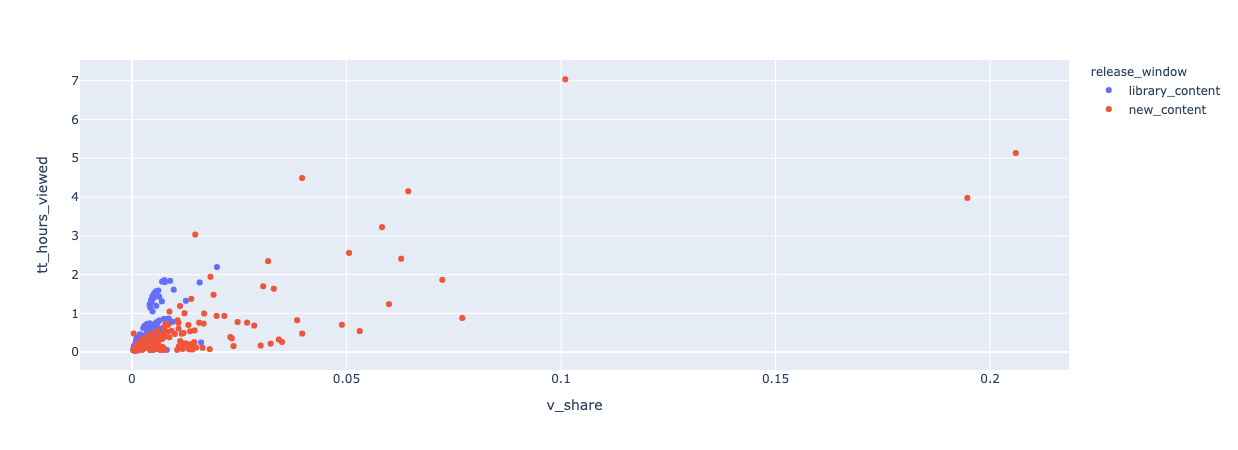

In [43]:
fig = px.scatter(hours_viewed_vs, x="v_share", y="tt_hours_viewed", color='release_window')
fig.show()

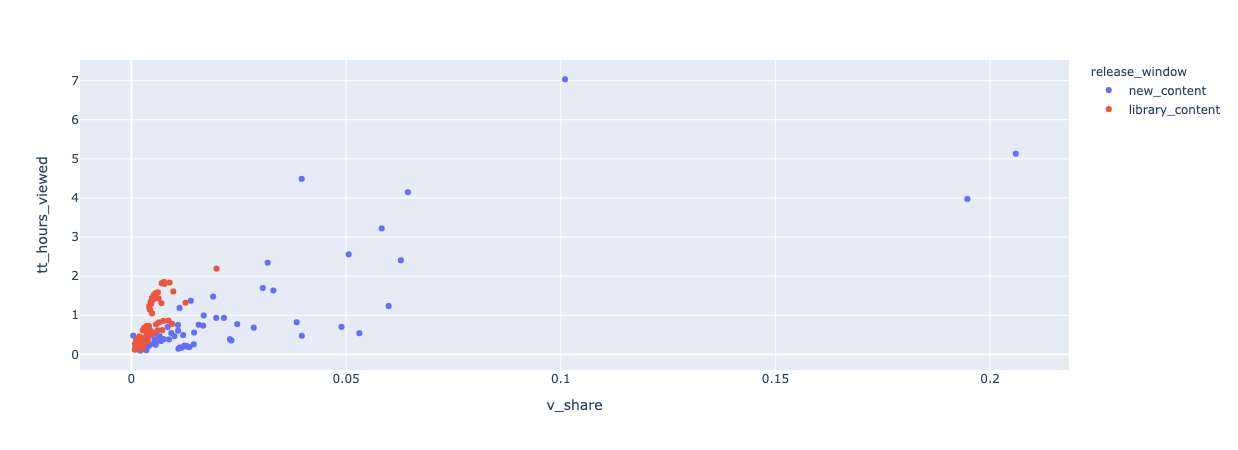

In [46]:
plot_df = hours_viewed_vs[hours_viewed_vs['content_category'] == 'series']
fig = px.scatter(plot_df, x="v_share", y="tt_hours_viewed", color='release_window')
fig.show()
#### Series

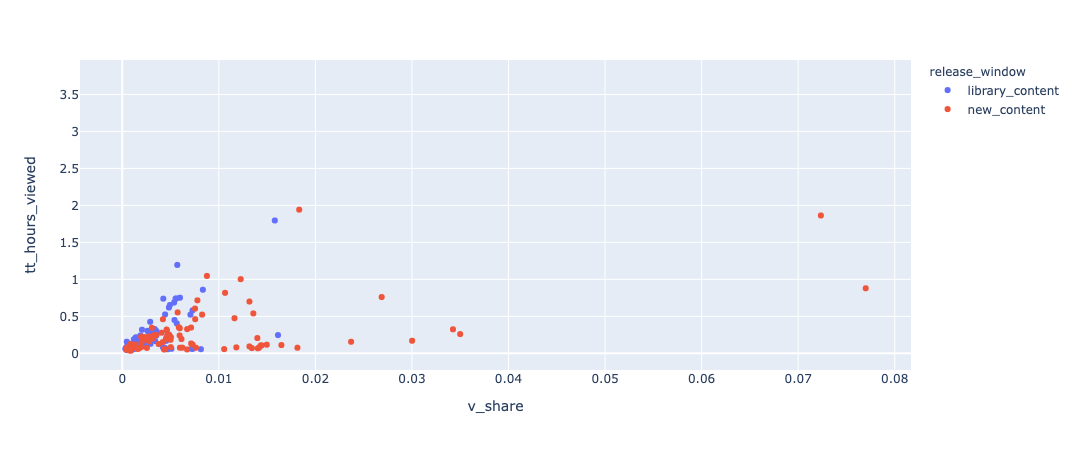

In [47]:
plot_df = hours_viewed_vs[hours_viewed_vs['content_category'] == 'movies']
fig = px.scatter(plot_df, x="v_share", y="tt_hours_viewed", color='release_window')
fig.show()

In [48]:
hours_viewed.head()

,title_name,title_id,season_number,offering_start_date,air_date,asset_run_time_hours,content_category,program_type,medal,pillar_genre,is_pay_1,is_popcorn,medal_number,age_of_content,content_cost,average_hours_viewed,log_average_hours_viewed,pred_logged,prediction,pct_error
0,It,GWt7vKAJzFri8vQEAAAKm,0,2020-10-27,2017-01-01,2.1964,movies,acquired,None,Horror,0,0,4,3.8194,9029193,0.0585,-4.0943,-4.1212,0.0575,0.0185
1,Snow White and the Huntsman,GX42eRA3gLmNViQEAAAYP,0,2020-12-01,2012-06-01,2.0739,movies,acquired,None,Action/Adventure,0,0,4,8.5012,3646400,0.0484,-4.3680,-3.5002,0.0884,0.8249
2,The Bee Gees: How Can You Mend A Broken Heart,GX5lfBgOJ7RKRwgEAAAMG,0,2020-12-13,2020-12-12,1.8503,movies,original,Silver,Documentary,0,0,2,0.0027,4500000,0.1034,-3.2737,-3.5817,0.0835,0.1922
3,Deathstroke: Knights & Dragons,GX9jvbw7CW3idqQEAAABV,0,2021-01-01,2020-08-18,1.4161,movies,acquired,None,Action/Adventure,0,0,4,0.3724,1080000,0.0330,-4.9221,-3.8342,0.0701,1.1256
4,Chernobyl,GXJvkMAU0JIG6gAEAAAIo,1,2020-05-27,2019-06-03,5.2950,series,original,None,Drama,0,0,4,0.9829,16200000,0.0394,-4.6653,-3.9352,0.0654,0.6588


In [49]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [144]:
plot_df = plot_df[plot_df['days_on_hbo_max'] == 60]

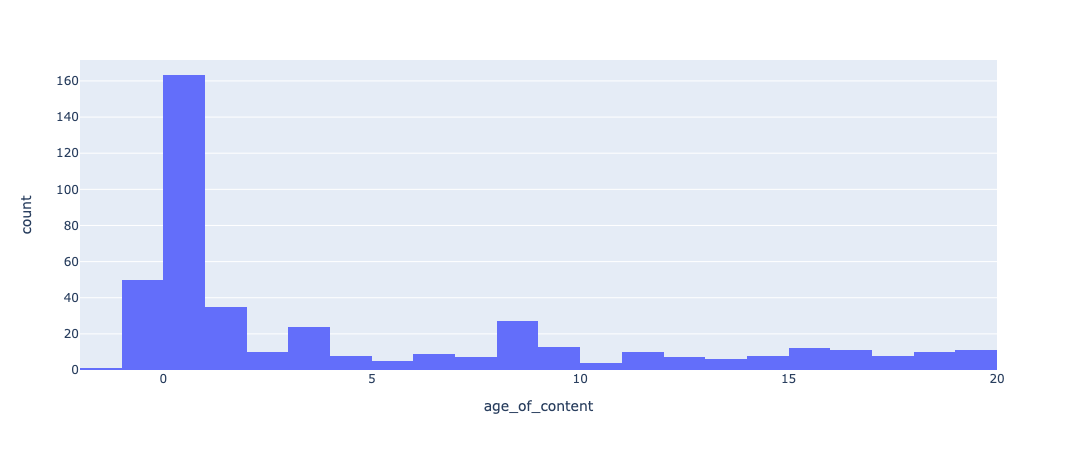

In [54]:
plot_df = hours_viewed[hours_viewed['age_of_content']<20]
fig = px.histogram(plot_df, x="age_of_content", nbins=40)
fig.show()

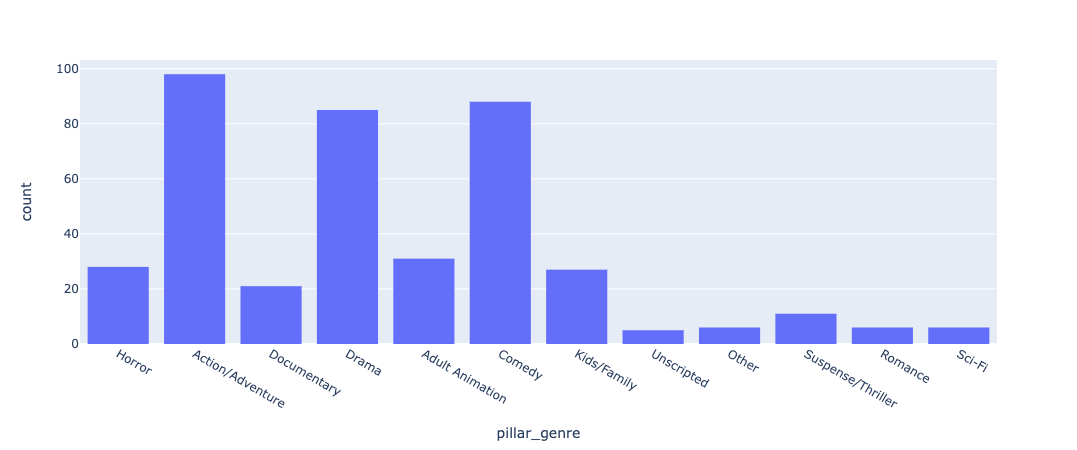

In [55]:
plot_df = hours_viewed[hours_viewed['age_of_content']<20]
fig = px.histogram(plot_df, x="pillar_genre", nbins=20)
fig.show()